# Task 1: Graph Cut Segmentation

This notebook demonstrates image segmentation using **GrabCut** algorithm combined with deep learning-based object detection.

## Objectives:
1. Generate bounding boxes for persons using a pretrained object detector (GroundingDINO)
2. Implement graph-based segmentation using OpenCV's `cv2.grabCut`
3. Compare results across 1, 3, and 5 iterations
4. Visualize original images, masks, segmented foreground, and overlays

## Importing Required Libraries

Loading necessary libraries for image processing, deep learning, and visualization.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib.patches as patches
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

## Configuring the Computation Device

Setting up GPU if available, otherwise defaulting to CPU for faster processing.

In [ ]:
# Select the device for computation (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device("cuda:2")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

using device: cuda:2


## GroundingDINO

**GroundingDINO** is a state-of-the-art open-set object detector that combines the power of DINO (DETR with Improved deNoising anchOr boxes) with language grounding capabilities. Unlike traditional object detectors that can only detect predefined classes, GroundingDINO performs **zero-shot detection** - it can detect any object described in natural language without prior training on that specific class.

### Key Features:
- **Language-Vision Fusion**: Integrates text and image features using cross-modality attention
- **Transformer-based Architecture**: Uses DETR-style encoder-decoder with denoising anchors
- **Zero-Shot Detection**: Can detect objects based on free-form text prompts
- **High Accuracy**: Achieves competitive performance on COCO and other benchmarks

### Architecture Overview:

![GroundingDINO Architecture](assets/Grounding_Dino.png)

The architecture consists of:
1. **Image Encoder**: Extracts visual features from input images (typically using Swin Transformer)
2. **Text Encoder**: Processes text prompts to generate language features (using BERT-like models)
3. **Feature Enhancer**: Fuses image and text features through cross-modality attention
4. **Decoder**: Generates object queries and predicts bounding boxes aligned with text descriptions

This makes GroundingDINO ideal for tasks requiring flexible object detection without retraining on new categories.

### Sources:
- **Official Repository**: [IDEA-Research/GroundingDINO](https://github.com/IDEA-Research/GroundingDINO)
- **Implementation Inspiration**: [Hugging Face - GroundingDINO](https://huggingface.co/docs/transformers/en/model_doc/grounding-dino)

## Defining the GroundingDINO Wrapper Class

Creating a wrapper class to simplify model loading and inference operations.

In [ ]:
class GDINO:
    """Wrapper class for GroundingDINO zero-shot object detection model."""
    
    def build_model(self, device=device):
        """
        Load the GroundingDINO model and processor from Hugging Face Hub.
        
        Args:
            device: Computation device (CPU or GPU)
        """
        model_id = "IDEA-Research/grounding-dino-base"
        print(f"Loading GroundingDINO from Hugging Face Hub: {model_id}")
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
        print("Model loaded successfully!")

    def predict(
        self,
        images_pil: list[Image.Image],
        texts_prompt: list[str],
        box_threshold: float,
        text_threshold: float,
    ) -> list[dict]:
        """
        Perform zero-shot object detection.
        
        Args:
            images_pil: List of PIL images
            texts_prompt: List of text prompts (e.g., ["Person"])
            box_threshold: Minimum confidence for bounding boxes
            text_threshold: Minimum confidence for text-image alignment
            
        Returns:
            List of detection results (boxes, scores, labels)
        """
        # Ensure prompts end with period for better performance
        texts_prompt = [prompt if prompt[-1] == "." else prompt + "." for prompt in texts_prompt]
        
        # Prepare inputs
        inputs = self.processor(
            images=images_pil, text=texts_prompt, padding=True, return_tensors="pt"
        ).to(self.model.device)
        
        # Run inference
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Post-process detections
        results = self.processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold,
            text_threshold=text_threshold,
            target_sizes=[k.size[::-1] for k in images_pil],
        )
        return results

## Initializing and Loading the Model

Creating the GDINO instance and loading pretrained weights from Hugging Face.

In [5]:
gdino = GDINO()

In [ ]:
gdino.build_model(device=device)

One or both local paths not provided. Loading from Hugging Face Hub: IDEA-Research/grounding-dino-base


## Defining Visualization Functions

Creating helper functions to visualize detection results:
- `plot_boxes_on_image()`: Draws bounding boxes on the original image
- `show_detected_crops()`: Displays cropped regions for each detected object

In [ ]:
def plot_boxes_on_image(image, boxes, labels=None, color='red', linewidth=2):
    """
    Plots bounding boxes on an image using Matplotlib.

    Args:
        image (Tensor | np.ndarray): The image tensor (C,H,W) or (H,W,C), can be on CUDA.
        boxes (Tensor): Bounding boxes tensor of shape (N, 4) in [x_min, y_min, x_max, y_max].
        labels (list, optional): Labels for each box.
        color (str): Color for the boxes.
        linewidth (int): Thickness of box border.
    """
    # Move image and boxes to CPU if on GPU
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu()
        if image.dim() == 3 and image.shape[0] in [1, 3]:  # CHW format
            image = image.permute(1, 2, 0)
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.detach().cpu()

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    # Draw boxes
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=linewidth,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        if labels:
            ax.text(
                x_min, y_min - 5, labels[i],
                color=color, fontsize=10, weight='bold',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
            )

    plt.axis('off')
    plt.show()



def show_detected_crops(image, boxes, scores=None, labels=None, min_size=0):
    """
    Show each detected box as a cropped image.
    
    Args:
        image (np.ndarray or torch.Tensor): Original image in RGB.
        boxes (Tensor or np.ndarray): Detected boxes (N, 4) in [x_min, y_min, x_max, y_max].
        scores (Tensor or list, optional): Confidence scores for detections.
        labels (list, optional): Detected class labels.
        min_size (int): Optional minimum pixel size (width or height) to filter tiny detections.
    """
     # Move image and boxes to CPU if on GPU
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().permute(1, 2, 0).numpy()
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.detach().cpu().numpy()

    crops = []
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = map(int, box)
        w, h = x_max - x_min, y_max - y_min
        if w < min_size or h < min_size:
            continue
        crop = image[y_min:y_max, x_min:x_max]
        crops.append((crop, scores[i] if scores is not None else None, labels[i] if labels is not None else None))

    # Plot each crop
    n = len(crops)
    if n == 0:
        print("No crops found with given size threshold.")
        return

    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, (crop, score, label) in zip(axes, crops):
        ax.imshow(crop)
        title = ""
        if label is not None:
            title += f"{label}"
        if score is not None:
            title += f" ({score:.2f})"
        ax.set_title(title)
        ax.axis("off")
    plt.show()


## Loading Input Images

Reading the two test images (asm-1.jpg and asm-2.jpg) for processing.

In [8]:
asm1_pil = Image.open("images/asm-1.jpg")
asm1_np = np.array(asm1_pil.convert("RGB"))
asm2_pil = Image.open("images/asm-2.jpg")
asm2_np = np.array(asm2_pil.convert("RGB"))

## Generating Bounding Boxes Using GroundingDINO

Detecting persons in both images using the pretrained zero-shot object detector:
- **Text prompt**: "Person"
- **Box threshold**: 0.3 (minimum confidence for bounding boxes)
- **Text threshold**: 0.25 (minimum confidence for text-image alignment)

In [9]:
predictions_asm1 = gdino.predict([asm1_pil],texts_prompt = ["Person"],
        box_threshold= 0.3,
        text_threshold= 0.25)
scores_asm1, boxes_asm1, labels_asm1 = predictions_asm1[0]["scores"], predictions_asm1[0]["boxes"], predictions_asm1[0]["text_labels"]
predictions_asm2 = gdino.predict([asm2_pil],texts_prompt = ["Person"],
        box_threshold= 0.3,
        text_threshold= 0.25)
scores_asm2, boxes_asm2, labels_asm2 = predictions_asm2[0]["scores"], predictions_asm2[0]["boxes"], predictions_asm2[0]["text_labels"]

### Visualizing Detection Results for Image 1 (asm-1.jpg)

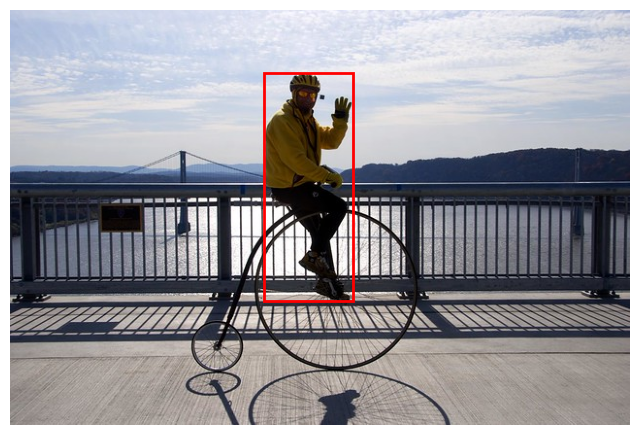

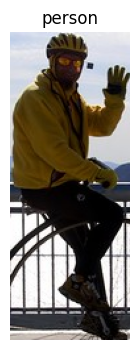

In [10]:
plot_boxes_on_image(asm1_np,boxes_asm1)
show_detected_crops(asm1_np, boxes_asm1, labels=labels_asm1)

### Visualizing Detection Results for Image 2 (asm-2.jpg)

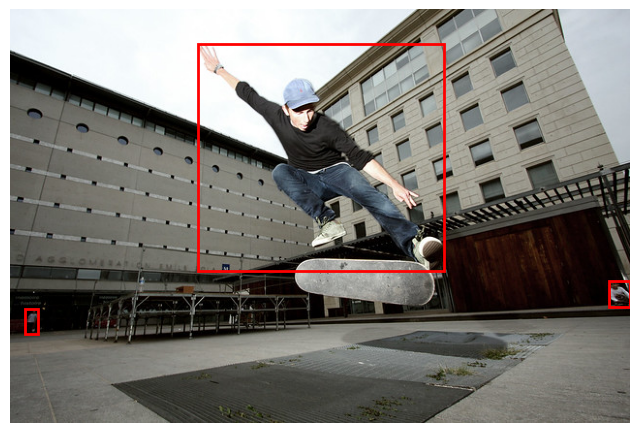

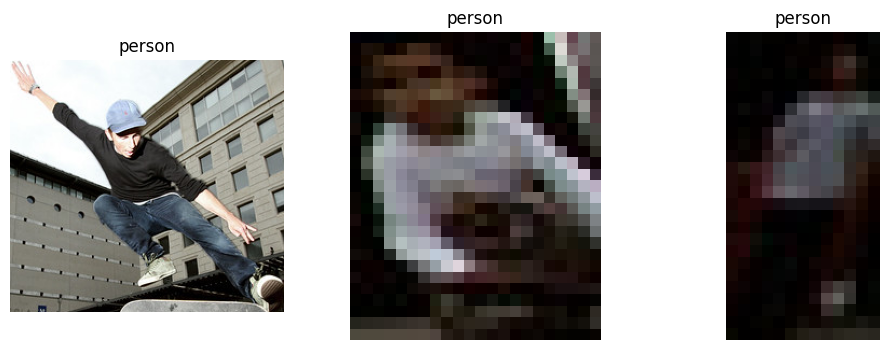

In [11]:
plot_boxes_on_image(asm2_np,boxes_asm2)
show_detected_crops(asm2_np, boxes_asm2, labels=labels_asm2)

It’s impressive that Grounding DINO successfully detected the distant, small-scale images of the persons, even though they appeared as minute patches in the frame and required significant zooming to recognize.

## GrabCut Segmentation

GrabCut is a powerful graph-based segmentation algorithm that uses:
- **Energy minimization** via graph cuts to separate foreground from background
- **Gaussian Mixture Models (GMM)** to model color distributions
- **Iterative refinement** to progressively improve segmentation quality

![GrabCut Architecture](assets/grabcut_scheme.jpg)


The `grabcut_segment()` function:
1. Expands bounding boxes slightly to capture surrounding context
2. Initializes foreground and background GMMs
3. Runs the GrabCut algorithm for the specified number of iterations
4. Returns a binary mask and the segmented foreground image


#### Sources:
- Interactive Foreground Extraction using GrabCut Algorithm. https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html
- Implementing the "GrabCut" Segmentation Technique as a Plugin for the GIMP. https://www.cs.ru.ac.za/research/g02m1682/

In [ ]:
def grabcut_segment(image, boxes, iter_count=5, expand_ratio=0.1):
    """
    Perform GrabCut segmentation using detected bounding boxes.
    
    Args:
        image: Input image (tensor or numpy array)
        boxes: Bounding boxes (N, 4) in [x_min, y_min, x_max, y_max] format
        iter_count: Number of GrabCut iterations
        expand_ratio: Ratio to expand bounding boxes for better context
        
    Returns:
        final_mask: Binary segmentation mask (1=foreground, 0=background)
        segmented: Segmented foreground image
    """
    # Convert to numpy if needed
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.detach().cpu().numpy()
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().permute(1, 2, 0).numpy()

    # Convert to BGR for OpenCV
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mask = np.zeros(img.shape[:2], np.uint8)
    h, w = img.shape[:2]

    # Initialize GMM models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Process each bounding box
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        
        # Expand bounding box for better context
        box_w = x_max - x_min
        box_h = y_max - y_min
        x_min = max(0, int(x_min - expand_ratio * box_w))
        y_min = max(0, int(y_min - expand_ratio * box_h))
        x_max = min(w - 1, int(x_max + expand_ratio * box_w))
        y_max = min(h - 1, int(y_max + expand_ratio * box_h))

        rect = (x_min, y_min, x_max - x_min, y_max - y_min)
        mask[y_min:y_max, x_min:x_max] = cv2.GC_PR_FGD

        # Run GrabCut algorithm
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, iter_count, cv2.GC_INIT_WITH_MASK)

    # Create final binary mask
    final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    segmented = image * final_mask[:, :, np.newaxis]
    return final_mask, segmented


def visualize_segmentation(image, mask, segmented):
    """Display original image, mask, and segmented result side by side."""
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("GrabCut Mask")
    ax[2].imshow(segmented)
    ax[2].set_title("Segmented Foreground")
    for a in ax:
        a.axis('off')
    plt.show()

### Applying GrabCut to Image 1 (5 iterations)

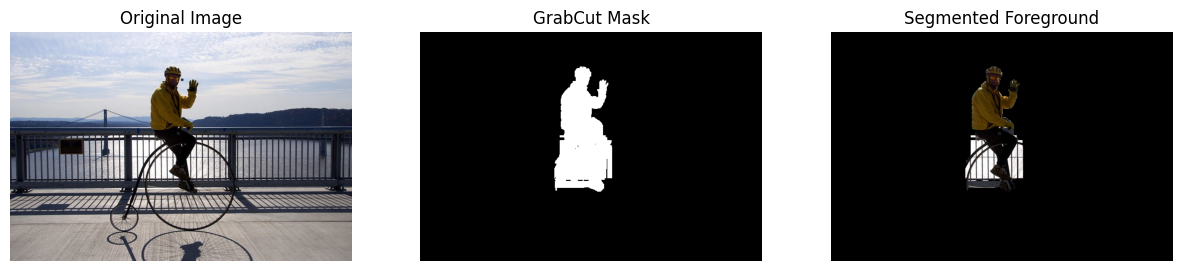

In [13]:
grabcut_mask_asm1, grabcut_segmented_asm1 =  grabcut_segment(asm1_np, boxes_asm1, iter_count=5, expand_ratio=0.1)
visualize_segmentation(asm1_np, grabcut_mask_asm1,grabcut_segmented_asm1)

### Applying GrabCut to Image 2 (5 iterations)

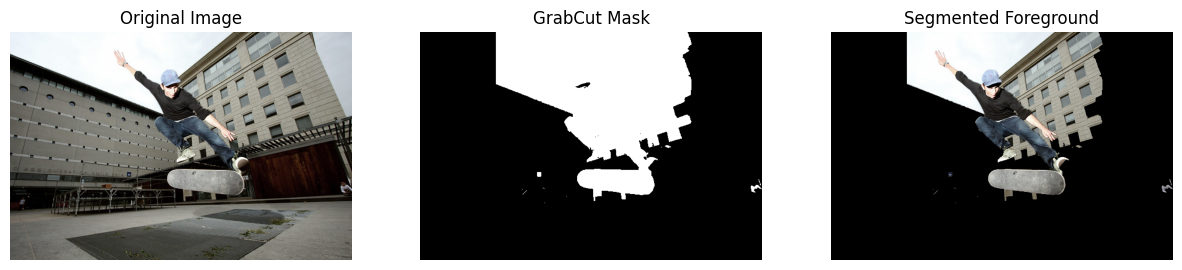

In [14]:
grabcut_mask_asm2, grabcut_segmented_asm2 =  grabcut_segment(asm2_np, boxes_asm2, iter_count=5, expand_ratio=0.2)
visualize_segmentation(asm2_np, grabcut_mask_asm2,grabcut_segmented_asm2)

## Comparing GrabCut Performance Across Iterations

Analyzing how different iteration counts (1, 3, and 5) affect segmentation quality:
- **Qualitative analysis**: Visual inspection of mask quality and boundary accuracy
- **Quantitative analysis**: Foreground ratio (percentage of pixels classified as foreground)

The visualization displays:
1. Original image for reference
2. Binary mask showing foreground (white) vs background (black)
3. Red overlay highlighting the segmented foreground region

In [ ]:
def visualize_grabcut_iterations(image, boxes, iterations=[1, 3, 5]):
    """
    Compare GrabCut results across different iteration counts.
    
    Args:
        image: Input image
        boxes: Bounding boxes for segmentation
        iterations: List of iteration counts to compare
        
    Displays:
        - Original image
        - Binary mask with foreground percentage
        - Red overlay showing segmented foreground
    """
    results = []

    # Run GrabCut for each iteration count
    for it in iterations:
        mask, segmented = grabcut_segment(image, boxes, iter_count=it)
        fg_ratio = (mask.sum() / mask.size) * 100  # Calculate foreground percentage
        results.append((it, mask, segmented, fg_ratio))

    # Visualize results
    fig, axes = plt.subplots(len(results), 3, figsize=(12, 10))
    for i, (it, mask, segmented, fg_ratio) in enumerate(results):
        # Create overlay with red highlighting
        overlay = image.copy().astype(np.uint8)
        overlay_mask = (mask > 0)
        overlay[overlay_mask] = (overlay[overlay_mask] * 0.5 + np.array([255, 0, 0]) * 0.5).astype(np.uint8)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Original (Iter={it})")

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Mask | FG={fg_ratio:.1f}%")

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay (Foreground in Red)")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

### Comparing Iterations for Image 1 (asm-1.jpg)

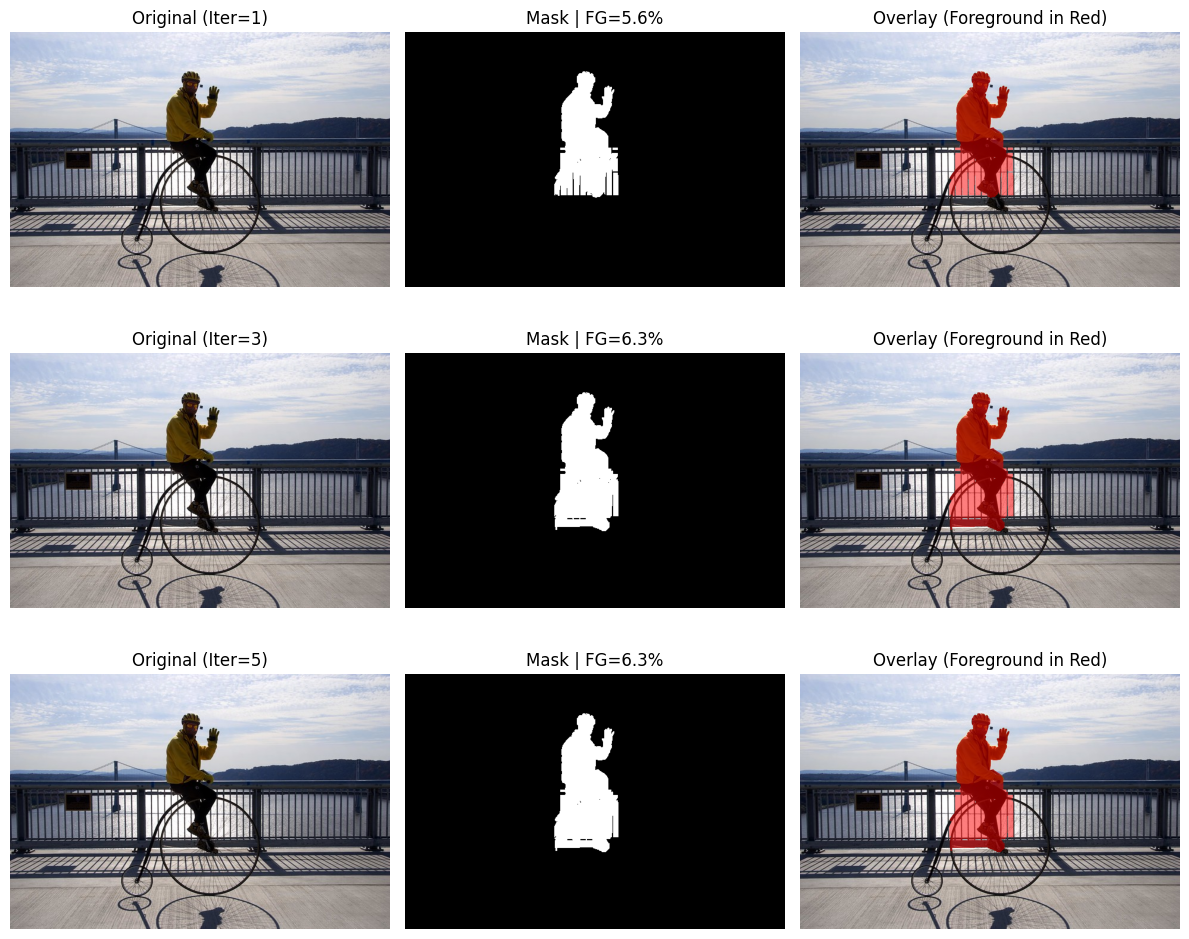

In [ ]:
visualize_grabcut_iterations(asm1_np, boxes_asm1, iterations = [1, 3, 5])

### Comparing Iterations for Image 2 (asm-2.jpg)

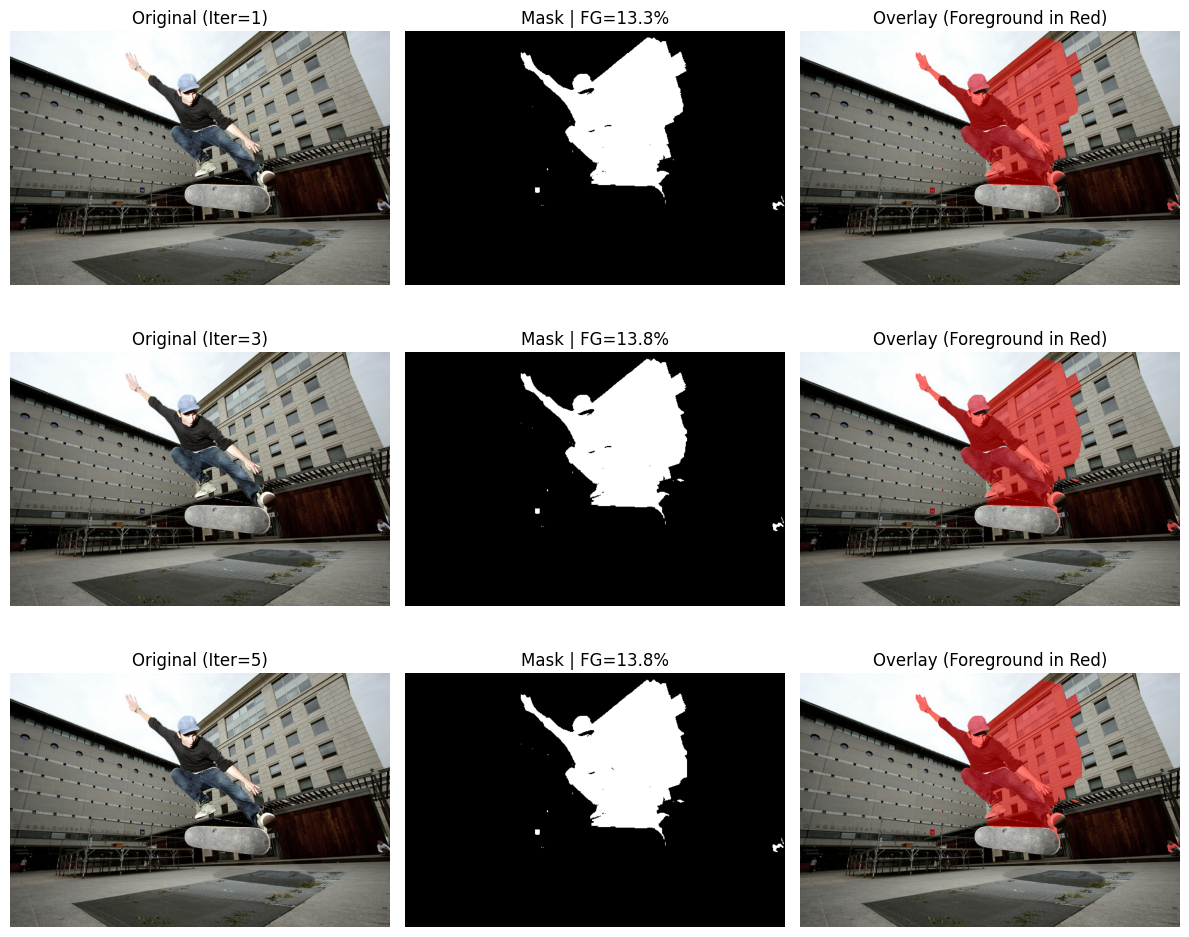

In [ ]:
visualize_grabcut_iterations(asm2_np, boxes_asm2, iterations = [1, 3, 5])

## Observations and Analysis

### Qualitative Differences:
- **1 iteration**: Rough, initial segmentation often includes background noise and misses fine details.
- **3 iterations**: Clearly improved boundary refinement and better foreground/background separation; thin structures and edges become more coherent.
- **5 iterations**: Even more accurate segmentation with smoother edges and slightly better detail recovery, but visually very similar to the 3-iteration result (diminishing returns beyond 3).

### Quantitative Differences:
- Measured foreground ratios (FG%):
    - asm-2.jpg: Iter 1 = 13.3%, Iter 3 = 13.8%, Iter 5 = 13.8% (absolute increase +0.5 pp; ≈ +3.8% relative).
    - asm-1.jpg: Iter 1 = 5.62%, Iter 3 = 6.3%, Iter 5 = 6.3% (absolute increase +0.68 pp; ≈ +12.1% relative).
- The increases are modest in absolute terms, indicating GrabCut refines boundaries to include a few more foreground pixels.
- Identical FG% at iterations 3 and 5 for both images indicates the algorithm stabilizes by 3 iterations for these cases.

### Key Findings:
1. GroundingDINO reliably detected persons in both images with sufficient boxes to initialize segmentation.
2. GrabCut improves segmentation noticeably from iteration 1 to 3, capturing additional foreground (thin structures or boundary pixels).
3. Most improvement occurs by 3 iterations; iteration 5 gives minor visual tweaks but little quantitative gain, so 3 iterations are a good trade-off between quality and compute.
4. The combined DL-detection + graph-based GrabCut workflow yields robust results; small FG% increases reflect refined masks rather than gross over-segmentation.